In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import Polygon

# Ecapsulation
I packaged 2 classes:
one for a single frame `EvoluteFrame`, and another for containing multiple frames.

In [21]:
class EvoluteFrame:
    def __init__(self,
                 x=None, y=None, w=None, h=None, theta=None):
        self.x = x if x is not None else np.random.uniform(0, 10)
        self.y = y if y is not None else np.random.uniform(0, 10)
        self.w = w if w is not None else np.random.uniform(1, 5)
        self.h = h if h is not None else np.random.uniform(1, 5)
        self.theta = theta if theta is not None else np.random.uniform(0, 2 * np.pi)
        self.position = self.__get_position()
        self.path = Path(self.position)

        self.sigma_x = 0.5
        self.sigma_y = 0.5
        self.sigma_w = 0.5
        self.sigma_h = 0.5
        self.sigma_theta = 0.5

    def __get_position(self):
        '''
        self.x, self.y is the center,
        self.w is the width, self.h is the height,
        and the theta is the rotation.
        return the 4 points for the rectangle
        '''
        wc = self.w*np.cos(self.theta)/2
        ws = self.w*np.sin(self.theta)/2
        hc = self.h*np.cos(self.theta)/2
        hs = self.h*np.sin(self.theta)/2

        x1 = self.x - wc - hs
        y1 = self.y + ws - hc

        x2 = self.x - wc + hs
        y2 = self.y + ws + hc

        x3 = self.x + wc + hs
        y3 = self.y - ws + hc

        x4 = self.x + wc - hs
        y4 = self.y - ws - hc

        return np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])

    def update_position(self):
        self.position = self.__get_position()
        self.path = Path(self.position)
    def get_position(self):
        return self.position
    def is_in_rect(self, point):
        return self.path.contains_point(point)

    def calculate_score(self, points, flag):
        '''
        if the points are in the rectangle, return 1,
        else return the 1/d where d is the distance from the point to the center.
        '''
        position = self.get_position()
        score = 0
        for i in range(len(points)):
            if self.is_in_rect(points[i]):
                if flag[i] == 0:
                    flag[i] = 1
                    score += 1/np.linalg.norm(points[i] - [self.x, self.y])
            # else:
            #     score += 1/(1+np.linalg.norm(points[i] - [self.x, self.y]))
        # score -= 0.01*(self.w+self.h)
        return score

    # easy for printing x,y,w,h,theta
    def __str__(self):
        return f'x: {self.x}, y: {self.y}, w: {self.w}, h: {self.h}, theta: {self.theta}'

    def generate_offsprint(self):
        x_star = np.random.normal(self.x, self.sigma_x)
        y_star = np.random.normal(self.y, self.sigma_y)
        w_star = np.random.normal(self.w, self.sigma_w)
        h_star = np.random.normal(self.h, self.sigma_h)
        theta_star = np.random.normal(self.theta, self.sigma_theta)
        return EvoluteFrame(x_star, y_star, w_star, h_star, theta_star)

## Boxes
Contains 2 boxes. **I only write code for binary clustering** (because I use flag 1 and 0 for classifying which centroid the point belongs to). So if you want to see results with different `num_clusters`, it can only be tuned in 1 or 2.

In [22]:

class Boxes:
    def __init__(self, num_clusers, points, flags, boxes = None):
        self.boxes = boxes if boxes is not None else [EvoluteFrame() for _ in range(num_clusers)]
        self.score = self.calculate_score(points, flags)
        # for b in self.boxes:
        #     print(b)


    def calculate_score(self, points, flags):
        self.score = np.sum([box.calculate_score(points, flags) for box in self.boxes])
        return self.score

    def generate_offspring(self, num_cluster, points, flags):
        new_boxes = []
        for b in self.boxes:
            b = b.generate_offsprint()
            new_boxes.append(b)
        return Boxes(num_cluster, points, flags, new_boxes)



Generate the samples

In [23]:
# (2.5，7.5) as center, r = 2.0
theta2 = np.random.uniform(0, 2 * np.pi, 33)
r2 = 2.0 * np.sqrt(np.random.uniform(0, 1, 33))
x2 = 2.5 + r2 * np.cos(theta2)
y2 = 7.5 + r2 * np.sin(theta2)
group2 = np.vstack((x2, y2)).T

# (7.5, 2.5) as center, r = 2.0
theta3 = np.random.uniform(0, 2 * np.pi, 33)
r3 = 2.0 * np.sqrt(np.random.uniform(0, 1, 33))
x3 = 7.5 + r3 * np.cos(theta3)
y3 = 2.5 + r3 * np.sin(theta3)
group3 = np.vstack((x3, y3)).T

points = np.vstack((group2, group3))
flag = np.zeros(66)

## Evolute
50 parents and 100 for the size of the group.
The first 50 highest score will be chosen as the new parents.

In [24]:


def evolving_clusters(points, num_clusters, num_generations=1000):
    total_number = 100
    parent_number = 50
    hyperboxes = [Boxes(num_clusters, points, flag.copy()) for _ in range(parent_number)]
    # 对hyperboxes排序。分数最高的排在前面。
    hyperboxes.sort(key=lambda x: x.score, reverse=True)
    best_fitness = hyperboxes[0].score
    plt.figure()
    # print the init
    plt.scatter(points[:, 0], points[:, 1], c='blue', marker='x')
    for hyperbox in hyperboxes[0].boxes:
        polygon = Polygon(hyperbox.get_position(), closed=True, fill=False, edgecolor='red', linewidth=2)
        plt.gca().add_patch(polygon)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Evolving Clusters with Rotatable Hyperboxes Init')
    plt.show()
    epo = 0
    for generation in range(num_generations):

        for i in range(total_number):
            hyperboxes.append(hyperboxes[i].generate_offspring(num_clusters, points, flag.copy()))
        hyperboxes.sort(key=lambda x: x.score, reverse=True)
        hyperboxes = hyperboxes[:parent_number]
        if generation % int(num_generations/10) == 0:
            print(f"{epo*10.0}% finished!")
            epo = epo+1
    print('finished!')


    return hyperboxes[0].boxes

# Main Code
The first graph shows the initial state for the best individual, and after 1000 generations, the final graph is shown below, that is better than the ancestor.
And if you have enough time, you can upper the num_generations to obtain better results, but it cost time.

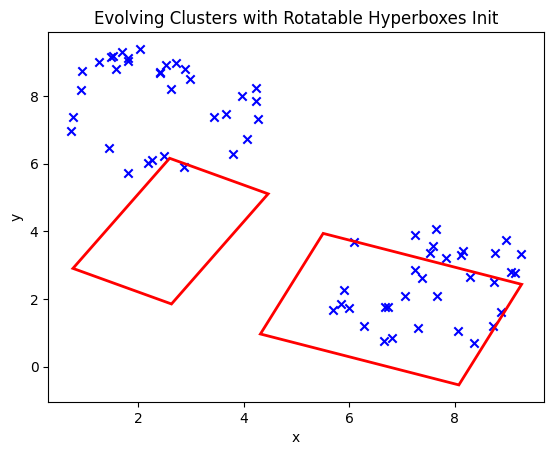

0.0% finished!
10.0% finished!
20.0% finished!
30.0% finished!
40.0% finished!
50.0% finished!
60.0% finished!
70.0% finished!
80.0% finished!
90.0% finished!
finished!


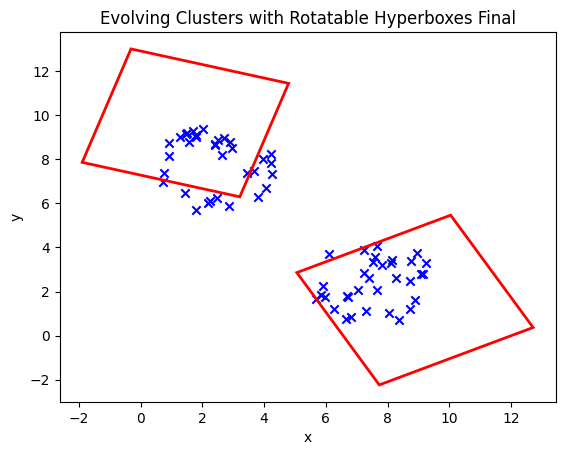

In [27]:
num_clusters = 2
hyperboxes = evolving_clusters(points, num_clusters, 1000)

# 可视化结果
plt.figure()
# 可视化结果
plt.scatter(points[:, 0], points[:, 1], c='blue', marker='x')
for hyperbox in hyperboxes:
    polygon = Polygon(hyperbox.get_position(), closed=True, fill=False, edgecolor='red', linewidth=2)
    plt.gca().add_patch(polygon)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Evolving Clusters with Rotatable Hyperboxes Final')
plt.show()

Because the stratage is randomly choice, sometime the result might not be so good. And this jupyter notebook file is also available on [Ethy9160-github](https://github.com/Ethylene9160/SDM359_Advanced_Machine_Learning/tree/master/assignment/ass15/ass15.ipynb).